In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import utils.metrics_utils as mu

# import torch_geometric
# import torch_sparse
# from torch_geometric.nn import MessagePassing
# import esm
import numpy as np
import os

# import requests
import json
from tqdm import tqdm
import pandas as pd

# import matplotlib.pyplot as plt
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

# from torchvision import datasets
# from torchvision.transforms import ToTensor
from sklearn import metrics
import torch.optim as optim

path = "Data/AlphaFoldDBEncoded"
AlphaFoldResults = [
    f[:-3]
    for f in os.listdir(path)
    if (os.path.isfile(path + "/" + f) & f.__contains__(".pt"))
]

# The following 3 proteins did not match between AlphaFold and the supplied JSON. Running the code to find these took a very long time.
BlackListProteins = ["Q841A2", "D6R8X8", "Q8I2A6"]

proteinIDs = []
AlphaFoldResultsSet = set(AlphaFoldResults)


# Get proteins where:
#   Is in AlphaFold
#   Is atmost 1500 amino acids long
#   Is not in blacklist (AlphaFold and JSON sequence does not match)
with open("Data/DeepTMHMM.partitions.json", "r") as FileObj:
    CVs = json.loads(FileObj.read())
    for cv in CVs.keys():
        cvProteins = CVs[cv]
        for idx, protein in enumerate(cvProteins):
            if protein["sequence"].__len__() > 1_500:
                continue
            if protein["id"] in BlackListProteins:
                continue
            if protein["id"] in AlphaFoldResultsSet:
                proteinIDs += [
                    [
                        protein["id"],
                        protein,
                        protein["sequence"],
                        protein["labels"],
                        cv,
                        idx,
                    ]
                ]


columns = ["proteinID", "protein", "sequence", "labels", "CV", "index"]
proteinMap = pd.DataFrame(proteinIDs, columns=columns)
proteinMap.index = proteinMap["proteinID"].values


encode_length = 1500
LABELS = {"I": 0, "O": 1, "P": 2, "S": 3, "M": 4, "B": 5, "X": -1}


def EncodeLabel(label):
    return [LABELS[lab] for lab in label]


class CustomProteinDataset(Dataset):
    def __init__(self, protein_code, transform=None, target_transform=None):
        self.proteins = proteinMap.loc[protein_code][["proteinID", "labels"]]
        self.transform = transform
        self.target_transform = target_transform
        self.proteinsEncoded = []
        self.labels = []
        print("encoding proteins")
        for index, protein in tqdm(self.proteins.iterrows()):
            latent = torch.load(path + "/" + protein["proteinID"] + ".pt")
            tempRotte = torch.cat([latent, torch.ones((latent.shape[0], 1)),],1,)
            # self.proteinsEncoded += []
            self.proteinsEncoded += [torch.cat([tempRotte, torch.zeros((encode_length - latent.shape[0], latent.shape[1] + 1)),],0,)]
            self.labels += [torch.tensor(EncodeLabel(protein["labels"].ljust(encode_length, "X")))]
        
        self.proteinsEncoded = torch.stack(self.proteinsEncoded, 0).permute(0, 2, 1)
        self.labels = torch.stack(self.labels, 0)

    def __len__(self):
        return self.proteinsEncoded.shape[0]

    def __getitem__(self, idx):
        encodeLatent = self.proteinsEncoded[idx]
        label = self.labels[idx]
        if self.transform:
            encodeLatent = self.transform(encodeLatent)
        if self.target_transform:
            label = self.target_transform(label)
        return encodeLatent, label


# Model
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.num_classes = num_classes
        self.channels = 512
        self.length = 1500
        self.hidden1 = 128
        batchnorm = nn.BatchNorm1d

        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv1d(self.channels, self.hidden1, 9, padding=4),
            batchnorm(self.hidden1),
            activation_fn(),
            nn.Conv1d(self.hidden1, self.num_classes, 7, padding=3),
        )

    def forward(self, x):
        return self.net(x)


# Accuracy
def accuracy(target, pred):
    return metrics.accuracy_score(
        target.detach().cpu().numpy(), pred.detach().cpu().numpy()
    )

print_error_type_pairs = False

c:\Users\jonas\anaconda3\envs\DeepLearningProject\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initiate the model
n_unique_labels = 7
model = Model(n_unique_labels)

# Loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


cv0Indices = list(proteinMap[proteinMap.CV == "cv0"].index.values)

train_dataset = CustomProteinDataset(cv0Indices[0:553])
test_dataset = CustomProteinDataset(cv0Indices[553:691])

batch_size = 32
# define a data loader to iterate the dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False
)

num_epochs = 20
validation_every_steps = 50

step = 0
model.train()

train_accuracies = []
valid_accuracies = []


step_history = []
type_accuracy_history = []

tm_type_accuracy_history = []
sptm_type_accuracy_history = []
sp_type_accuracy_history = []
glob_type_accuracy_history = []
beta_type_accuracy_history = []

tm_topology_accuracy_history = []
sptm_topology_accuracy_history = []
sp_topology_accuracy_history = []
glob_topology_accuracy_history = []
beta_topology_accuracy_history = []

print("Running Training loop")

for epoch in range(num_epochs):
    train_accuracies_batches = []

    for batch in train_loader:
        inputs, targets = batch
        output = model(inputs[:, :-1, :])

        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy
        predictions = output.max(1)[1]

        # Calculate accuracy for each protein in batch
        # prediction_labels_list = []
        # target_labels_list = []
        for idx in range(predictions.shape[0]):
            target_len = int(torch.sum(inputs[idx, -1, :]))
            train_accuracies_batches.append(
                accuracy(targets[idx][0:target_len], predictions[idx][0:target_len])
            )

        if step % validation_every_steps == 0:
            # Append everage training accuracy to list
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compite accuracies on validation set
            valid_accuracies_batches = []

            # For confusion matrix
            prediction_labels_list = []
            target_labels_list = []

            with torch.no_grad():
                model.eval()
                # Change this to test_loader once this exists
                for batch_test in test_loader:
                    inputs, targets = batch_test

                    # inputs, targets = inputs.to(DEVICE), targets.to(DEVICE) # Probably change this!!
                    output = model(inputs[:, :-1, :])
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    for idx in range(predictions.shape[0]):
                        # target_len represents the length of the targets non padded length
                        target_len = int(torch.sum(inputs[idx, -1, :]))

                        valid_accuracies_batches.append(
                            accuracy(
                                targets[idx][0:target_len],
                                predictions[idx][0:target_len],
                            )
                        )

                        prediction_labels_list += [predictions[idx][0:target_len]]
                        target_labels_list += [targets[idx][0:target_len]]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    # valid_accuracies_batches.append(
                    #     accuracy(targets[0:500], predictions[0:500]) * len(inputs)
                    # )

                    model.train()

            # Calcucalte and prind confusion matrix

            valid_accuracies.append(
                np.sum(valid_accuracies_batches) / len(test_dataset)
            )
            print(f"Step {step:<5}")
            print(f"  training accuracy:    {train_accuracies[-1]}")
            print(f"  test accuracy:        {valid_accuracies[-1]}")

            # Extra accuracies
            (
                error_type_pairs,
                confusion_matrix,
                type_accuracy,
                detailed_type_accuracy,
            ) = mu.confusionMatrix(prediction_labels_list, target_labels_list)

            # type accuracy is average of per type, topology accuracy
            print(f"  type accuracy (test): {type_accuracy}")

            # detailed type accuracies
            for key in detailed_type_accuracy.keys():
                print(f"  {key}")
                for field in detailed_type_accuracy[key].keys():
                    print(f"    {field:<9}: {detailed_type_accuracy[key][field]}")

            print(confusion_matrix)

            if print_error_type_pairs:
                for error_pair in error_type_pairs:
                    print("  Predicted topology:", error_pair["predicted topology"])
                    print("  Target topology:   ", error_pair["target topology"])

            print("")

            # Store values for plot
            step_history += [step]
            type_accuracy_history += [type_accuracy]

            tm_type_accuracy_history += [detailed_type_accuracy["tm"]["type"]]
            sptm_type_accuracy_history += [detailed_type_accuracy["sptm"]["type"]]
            sp_type_accuracy_history += [detailed_type_accuracy["sp"]["type"]]
            glob_type_accuracy_history += [detailed_type_accuracy["glob"]["type"]]
            beta_type_accuracy_history += [detailed_type_accuracy["beta"]["type"]]

            tm_topology_accuracy_history += [detailed_type_accuracy["tm"]["topology"]]
            sptm_topology_accuracy_history += [detailed_type_accuracy["sptm"]["topology"]]
            sp_topology_accuracy_history += [detailed_type_accuracy["sp"]["topology"]]
            glob_topology_accuracy_history += [detailed_type_accuracy["glob"]["topology"]]
            beta_topology_accuracy_history += [detailed_type_accuracy["beta"]["topology"]]


print("Done training.")

encoding proteins


0it [00:00, ?it/s]

553it [00:01, 309.64it/s]


encoding proteins


138it [00:00, 297.99it/s]


Running Training loop
Step 50   
  training accuracy:    0.8258512612222491
  test accuracy:        0.785061144406341
  type accuracy (test): 0.6775490045547485
  tm
    type     : 0.5714285969734192
    topology : 0.0
  sptm
    type     : 1.0
    topology : 0.0
  sp
    type     : 0.9459459185600281
    topology : 0.9459459185600281
  glob
    type     : 0.37037035822868347
    topology : 0.37037035822868347
  beta
    type     : 0.5
    topology : 0.0
tensor([[ 8,  3,  3,  0,  0,  0,  0],
        [ 0,  4,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0, 35,  1],
        [ 2,  1, 16,  0,  0, 30, 32],
        [ 0,  0,  1,  0,  1,  0,  0]])

Step 100  
  training accuracy:    0.8561538123642176
  test accuracy:        0.8333574637014631
  type accuracy (test): 0.7988369464874268
  tm
    type     : 0.5714285969734192
    topology : 0.0
  sptm
    type     : 1.0
    topology : 0.0
  sp
    type     : 0.8918918967247009
    topology : 0.8918918967247009
  glob
    type     : 0.530864179

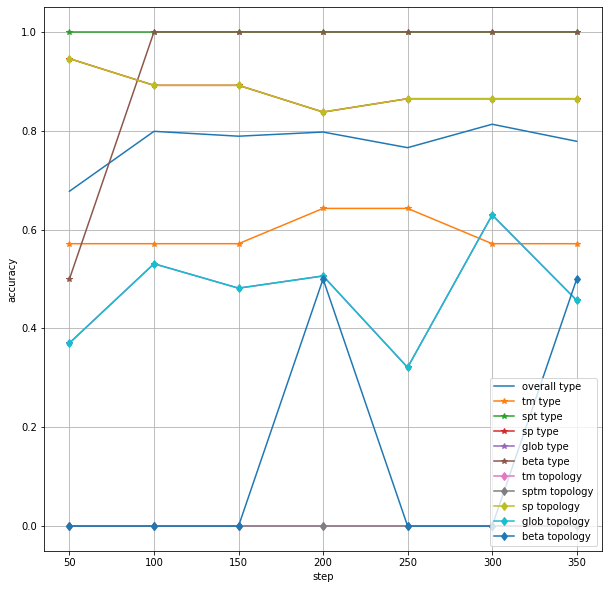

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))

axs.plot(step_history,type_accuracy_history,label="overall type")

axs.plot(step_history,tm_type_accuracy_history, "-*", label="tm type")
axs.plot(step_history,sptm_type_accuracy_history, "-*", label="spt type")
axs.plot(step_history,sp_type_accuracy_history, "-*", label="sp type")
axs.plot(step_history,glob_type_accuracy_history, "-*", label="glob type")
axs.plot(step_history,beta_type_accuracy_history, "-*", label="beta type")

axs.plot(step_history,tm_topology_accuracy_history, "-d", label="tm topology")
axs.plot(step_history,sptm_topology_accuracy_history, "-d", label="sptm topology")
axs.plot(step_history,sp_topology_accuracy_history, "-d", label="sp topology")
axs.plot(step_history,glob_topology_accuracy_history, "-d", label="glob topology")
axs.plot(step_history,beta_topology_accuracy_history, "-d", label="beta topology")


axs.set_xlabel("step")
axs.set_ylabel("accuracy")
axs.grid(True)

plt.legend(loc="lower right")
plt.show()